Inspired by "part1_getting_started.ipynb" from hls4ml_tutorial

# Part1: Getting started

In [1]:
from __future__ import print_function # not sure if this is still necessary
import os, sys
sys.path.append(
    os.path.abspath(
        os.path.join(
            os.path.dirname('__file__'), '/scratch/yj2429/dune/common'))) # think this path needs to be corrected

from loaddata import *
from savedata import *
from preprocessdata import *

from config import * # 

import numpy as np
import tensorflow as tf


#import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.regularizers import l1
#from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.qconvolutional import QConv2D
from qkeras.quantizers import quantized_bits, quantized_relu

from sklearn.metrics import classification_report
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
%matplotlib inline
#import plotting
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
def QCNN_02(input_shape, num_classes, data_format):

    if data_format == 'channels_first':
        img_chnls, img_rows, img_cols = input_shape
    else:
        img_rows, img_cols, img_chnls = input_shape

    model = Sequential()
    model.add(QConv2D(4, kernel_size=(3, 3), kernel_quantizer=quantized_bits(6,0,alpha=1), input_shape=input_shape, data_format=data_format))
    model.add(QActivation(activation=quantized_relu(6), name='relu1'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(QConv2D(8, kernel_size=(3, 3), kernel_quantizer=quantized_bits(6,0,alpha=1)))
    model.add(QActivation(activation=quantized_relu(6), name='relu2'))
    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(QDense(8, kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
    model.add(QActivation(activation=quantized_relu(6), name='relu5'))
    model.add(QDense(num_classes, kernel_quantizer=quantized_bits(6,0,alpha=1), bias_quantizer=quantized_bits(6,0,alpha=1),
                 kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
    model.add(Activation(activation='softmax', name='softmax'))

    return model

CONFIG_YML='/scratch/yj2429/dune/models/dune_cnn_02/config.v2.yml'

In [4]:
def load_data():
    # Load configuration files.
    X_TRAIN_FILES = load_train_image_filenames(CONFIG_YML)
    X_VALID_FILES = load_valid_image_filenames(CONFIG_YML)
    X_TEST_FILES = load_test_image_filenames(CONFIG_YML)

    Y_TRAIN_FILES = load_train_label_filenames(CONFIG_YML)
    Y_VALID_FILES = load_valid_label_filenames(CONFIG_YML)
    Y_TEST_FILES = load_test_label_filenames(CONFIG_YML)

    X_train = np.array([], dtype=np.float).reshape(0, 64, 64)
    X_valid = np.array([], dtype=np.float).reshape(0, 64, 64)
    X_test = np.array([], dtype=np.float).reshape(0, 64, 64)
    y_train = np.array([], dtype=np.float)
    y_valid = np.array([], dtype=np.float)
    y_test = np.array([], dtype=np.float)

    # Load the data.

    # TODO: can I use lists?
    #X_train_list = [map(float, load_npz(x_train_file)) for x_train_file in X_TRAIN_FILES]

    for x_train_file in X_TRAIN_FILES:
        print("INFO: load data:", x_train_file)
        X_train = np.concatenate((X_train, load_npz(x_train_file)))

    for x_valid_file in X_VALID_FILES:
        print("INFO: load data:", x_valid_file)
        X_valid = np.concatenate((X_valid, load_npz(x_valid_file)))

    for x_test_file in X_TEST_FILES:
        print("INFO: load data:", x_test_file)
        X_test = np.concatenate((X_test, load_npz(x_test_file)))

    for y_train_file in Y_TRAIN_FILES:
        print("INFO: load data:", y_train_file)
        y_train = np.concatenate((y_train, load_npz(y_train_file)))

    for y_valid_file in Y_VALID_FILES:
        print("INFO: load data:", y_valid_file)
        y_valid = np.concatenate((y_valid, load_npz(y_valid_file)))

    for y_test_file in Y_TEST_FILES:
        print("INFO: load data:", y_test_file)
        y_test = np.concatenate((y_test, load_npz(y_test_file)))

    return (X_train, y_train, X_valid, y_valid, X_test, y_test)

In [5]:
def plot_summary(history):
    # List all data in history
    #print(history.history.keys())

    f, axarr = plt.subplots(1,2)

    # Summarize history for accuracy
    axarr[0].plot(history.history['acc'])
    axarr[0].plot(history.history['val_acc'])
    axarr[0].set_title('model accuracy')
    axarr[0].set_ylabel('accuracy')
    axarr[0].set_xlabel('epoch')
    axarr[0].legend(['train', 'test'], loc='upper left')

    # Summarize history for loss
    axarr[1].plot(history.history['loss'])
    axarr[1].plot(history.history['val_loss'])
    axarr[1].set_title('model loss')
    axarr[1].set_ylabel('loss')
    axarr[1].set_xlabel('epoch')
    axarr[1].legend(['train', 'test'], loc='upper left')

    plt.show()


In [6]:
if __name__ == '__main__':
    X_train, y_train, X_valid, y_valid, X_test, y_test = load_data()

    print('INFO: {} training samples, {} validation samples, {} testing samples'.format(len(X_train), len(X_valid), len(X_test)))

# Hyper-parameters
    batch_size = 1024
    epochs = 48
    #106 with 0.001 lr 48 with 0.002

    # Input image dimensions
    img_rows = 64
    img_cols = 64
    img_chnls = 1
    data_format = 'channels_last'

    # Output
    num_classes = 3

    # Data should be alread float32
    X_train = X_train.astype('float32')
    X_valid = X_valid.astype('float32')
    X_test = X_test.astype('float32')

INFO: load data: dataset/train-00-images-roi.npz
INFO: load data: dataset/train-01-images-roi.npz
INFO: load data: dataset/train-02-images-roi.npz
INFO: load data: dataset/train-03-images-roi.npz
INFO: load data: dataset/train-04-images-roi.npz
INFO: load data: dataset/train-05-images-roi.npz
INFO: load data: dataset/train-06-images-roi.npz
INFO: load data: dataset/train-07-images-roi.npz
INFO: load data: dataset/train-08-images-roi.npz
INFO: load data: dataset/train-09-images-roi.npz
INFO: load data: dataset/train-10-images-roi.npz
INFO: load data: dataset/train-11-images-roi.npz
INFO: load data: dataset/train-12-images-roi.npz
INFO: load data: dataset/train-13-images-roi.npz
INFO: load data: dataset/train-14-images-roi.npz
INFO: load data: dataset/train-15-images-roi.npz
INFO: load data: dataset/train-16-images-roi.npz
INFO: load data: dataset/train-17-images-roi.npz
INFO: load data: dataset/train-18-images-roi.npz
INFO: load data: dataset/train-19-images-roi.npz
INFO: load data: dat

In [7]:
    # Data pre-processing
    #(X_train, X_valid, X_test) = normalization_zscore(X_train, X_valid, X_test, axis=None)
    (X_train, X_valid, X_test) = normalization_zero_one(X_train, X_valid, X_test, axis=None)
    #(X_train, X_valid, X_test) = normalization_minus_plus_one(X_train, X_valid, X_test, axis=None)


In [8]:
    # Reshape images to 2D (CNN)
    if data_format == 'channels_first':
        X_train = X_train.reshape(X_train.shape[0], img_chnls, img_rows, img_cols)
        X_valid = X_valid.reshape(X_valid.shape[0], img_chnls, img_rows, img_cols)
        X_test = X_test.reshape(X_test.shape[0], img_chnls, img_rows, img_cols)
        input_shape = (img_chnls, img_rows, img_cols)
    else:
        X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_chnls)
        X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, img_chnls)
        X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_chnls)
        input_shape = (img_rows, img_cols, img_chnls)


In [9]:
    # Convert class vectors to binary class matrices
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_valid = tf.keras.utils.to_categorical(y_valid, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)

    # CNN (input shape = 64x64x1, output = 4 classes)
    model = QCNN_02(input_shape, num_classes, data_format)

    model.summary()
    loss = 'categorical_crossentropy'
    #optimizer = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
    #optimizer = RMSprop()
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
q_conv2d (QConv2D)           (None, 62, 62, 4)         40        
_________________________________________________________________
relu1 (QActivation)          (None, 62, 62, 4)         0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 4)         0         
_________________________________________________________________
q_conv2d_1 (QConv2D)         (None, 13, 13, 8)         296       
_________________________________________________________________
relu2 (QActivation)          (None, 13, 13, 8)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 8)           0

In [20]:
    # TODO: Test data augmentation:
    # https://towardsdatascience.com/image-augmentation-for-deep-learning-using-keras-and-histogram-equalization-9329f6ae5085
    #datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest')
    #datagen.fit(X_train)


model.fit(X_train, y_train, batch_size=batch_size, epochs=40, verbose=1, validation_data=(X_valid, y_valid))
model.save('model_QKeras/cnn_02.h5')
#else:
#from tensorflow.keras.models import load_model
#model = load_model('model_QKeras/cnn_02.h5')

print('INFO: Evaluation...')
score = model.evaluate(X_test, y_test, verbose=1)
print('INFO: Test loss:', score[0])
print('INFO: Test accuracy:', score[1])

print('INFO: Accuracy per class (Background = 0, Low-Energy=1, High-Energy = 2)')
    #print(y_test.shape[0], y_test.shape[1])
    #print(y_test[0])
    #print(y_test[1])
    #print(y_test[2])
y_test = np.argmax(y_test, axis=1) # Convert one-hot to index
    #print(y_test[0])
    #print(y_test[1])
    #print(y_test[2])
    # 'predict_classes' is only available for Sequential models
y_pred = model.predict_classes(X_test)


Train on 34210 samples, validate on 11403 samples
Epoch 1/40
34210/34210 [==============================] - 6s 184us/sample - loss: 1.0560 - accuracy: 0.3813 - val_loss: 0.9716 - val_accuracy: 0.6689
Epoch 2/40
34210/34210 [==============================] - 5s 143us/sample - loss: 0.9069 - accuracy: 0.5638 - val_loss: 0.8287 - val_accuracy: 0.7577
Epoch 3/40
34210/34210 [==============================] - 5s 155us/sample - loss: 0.7839 - accuracy: 0.8234 - val_loss: 0.7048 - val_accuracy: 0.8971
Epoch 4/40
34210/34210 [==============================] - 5s 155us/sample - loss: 0.6841 - accuracy: 0.8875 - val_loss: 0.6282 - val_accuracy: 0.8975
Epoch 5/40
34210/34210 [==============================] - 5s 151us/sample - loss: 0.6201 - accuracy: 0.8757 - val_loss: 0.5773 - val_accuracy: 0.9047
Epoch 6/40
34210/34210 [==============================] - 6s 164us/sample - loss: 0.5728 - accuracy: 0.8961 - val_loss: 0.5858 - val_accuracy: 0.9058
Epoch 7/40
34210/34210 [==========================

In [21]:
    #print(y_pred.shape[0], y_pred.shape[1])
    y_prob = model.predict(X_test)
    #print(y_prob.shape[0], y_prob.shape[1])

    pred_csv_file = open('label_prob_cnn.csv', 'w+')

    for i in range(y_prob.shape[0]):
        pred_csv_file.write('%d %f %f %f\n' %(y_test[i], y_prob[i][0], y_prob[i][1], y_prob[i][2]))

    #y_pred = y_prob.argmax(axis=1)
    #print(y_prob[0])
    #print(y_prob[1])
    #print(y_prob[2])

    print(classification_report(y_test, y_pred))

    #save_model(model, 'dune_cnn_02', './model')

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4027
           1       0.91      0.93      0.92      3970
           2       0.98      0.87      0.92      3417

    accuracy                           0.93     11414
   macro avg       0.94      0.93      0.93     11414
weighted avg       0.94      0.93      0.93     11414



In [22]:
#import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(y_test, np.argmax(y_keras,axis=1))))
plt.figure(figsize=(9,9))
#_ = plotting.makeRoc(y_test, y_keras, le.classes_)

Accuracy: 0.9330646574382337


<Figure size 648x648 with 0 Axes>

<Figure size 648x648 with 0 Axes>

In [23]:
from hls4ml.converters.keras_to_hls import keras_to_hls

def convert_from_keras_model_custom(model, output_dir='my-hls-test', project_name='myproject',
    fpga_part='xcku115-flvb2104-2-i', clock_period=5, hls_config={}):
    config = hls4ml.converters.create_vivado_config(output_dir=output_dir,
        project_name=project_name, fpga_part=fpga_part, clock_period=clock_period)
    config['KerasModel'] = model

    model_config = hls_config.get('Model', None)
    if model_config is not None:
        if not all(k in model_config for k in ('Precision', 'ReuseFactor')):
            raise Exception('Precision and ReuseFactor must be provided in the hls_config')
    else:
        model_config = {}
        model_config['Precision'] = 'ap_fixed<16,6>'
        model_config['ReuseFactor'] = '1'
    config['HLSConfig']['Model'] = model_config
    
    if 'LayerName' in hls_config:
        config['HLSConfig']['LayerName'] = hls_config['LayerName']
    
    if 'LayerType' in hls_config:
        config['HLSConfig']['LayerType'] = hls_config['LayerType']

    if 'Optimizers' in hls_config:
        config['HLSConfig']['Optimizers'] = hls_config['Optimizers']
    
    return keras_to_hls(config)

In [31]:
import hls4ml
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'
config = hls4ml.utils.config_from_keras_model(model, granularity='name')

print("-----------------------------------")
print("Configuration")

config['Model'] = {}
config['Model']['Strategy'] = 'Resource'
config['Model']['Precision'] = 'ap_fixed<16,6>'
config['Model']['ReuseFactor'] = 896

config['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'


print("-----------------------------------")
hls_model = convert_from_keras_model_custom(model,
                                                       hls_config=config,
                                                       output_dir='model_QKeras/hls4ml_prj',
                                                       fpga_part='xcku115-flvb2104-2-i')

Interpreting Sequential
Topology:
Layer name: q_conv2d, layer type: QConv2D
Layer name: relu1, layer type: QActivation
Layer name: max_pooling2d, layer type: MaxPooling2D
Layer name: q_conv2d_1, layer type: QConv2D
Layer name: relu2, layer type: QActivation
Layer name: max_pooling2d_1, layer type: MaxPooling2D
Layer name: q_dense, layer type: QDense
Layer name: relu5, layer type: QActivation
Layer name: q_dense_1, layer type: QDense
Layer name: softmax, layer type: Activation
-----------------------------------
Configuration
-----------------------------------
Interpreting Sequential
Input shape: [64, 64, 1]
Topology:
Layer name: q_conv2d, layer type: QConv2D, current shape: [[None, 64, 64, 1]]
Layer name: relu1, layer type: Activation, current shape: [[None, 62, 62, 4]]
Layer name: max_pooling2d, layer type: MaxPooling2D, current shape: [[None, 62, 62, 4]]
Layer name: q_conv2d_1, layer type: QConv2D, current shape: [[None, 15, 15, 4]]
Layer name: relu2, layer type: Activation, current

In [32]:
print(config)

{'Model': {'Strategy': 'Resource', 'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 896}, 'LayerName': {'input1': {'Precision': {'result': 'ap_fixed<16,6>'}}, 'q_conv2d': {'Precision': {'weight': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'relu1': {'Precision': {'result': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'max_pooling2d': {'Precision': 'ap_fixed<16,6>'}, 'q_conv2d_1': {'Precision': {'weight': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'relu2': {'Precision': {'result': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'max_pooling2d_1': {'Precision': 'ap_fixed<16,6>'}, 'q_dense': {'Precision': {'weight': 'ap_fixed<7,1>', 'bias': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'relu5': {'Precision': {'result': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'q_dense_1': {'Precision': {'weight': 'ap_fixed<7,1>', 'bias': 'ap_fixed<7,1>'}, 'ReuseFactor': 1}, 'softmax': {'Precision': 'ap_fixed<16,6>', 'ReuseFactor': 1, 'table_size': 1024, 'exp_table_t': 'ap_fixed<18,8>', 'inv_table_t': 'ap_fixed<18,4>'}}}


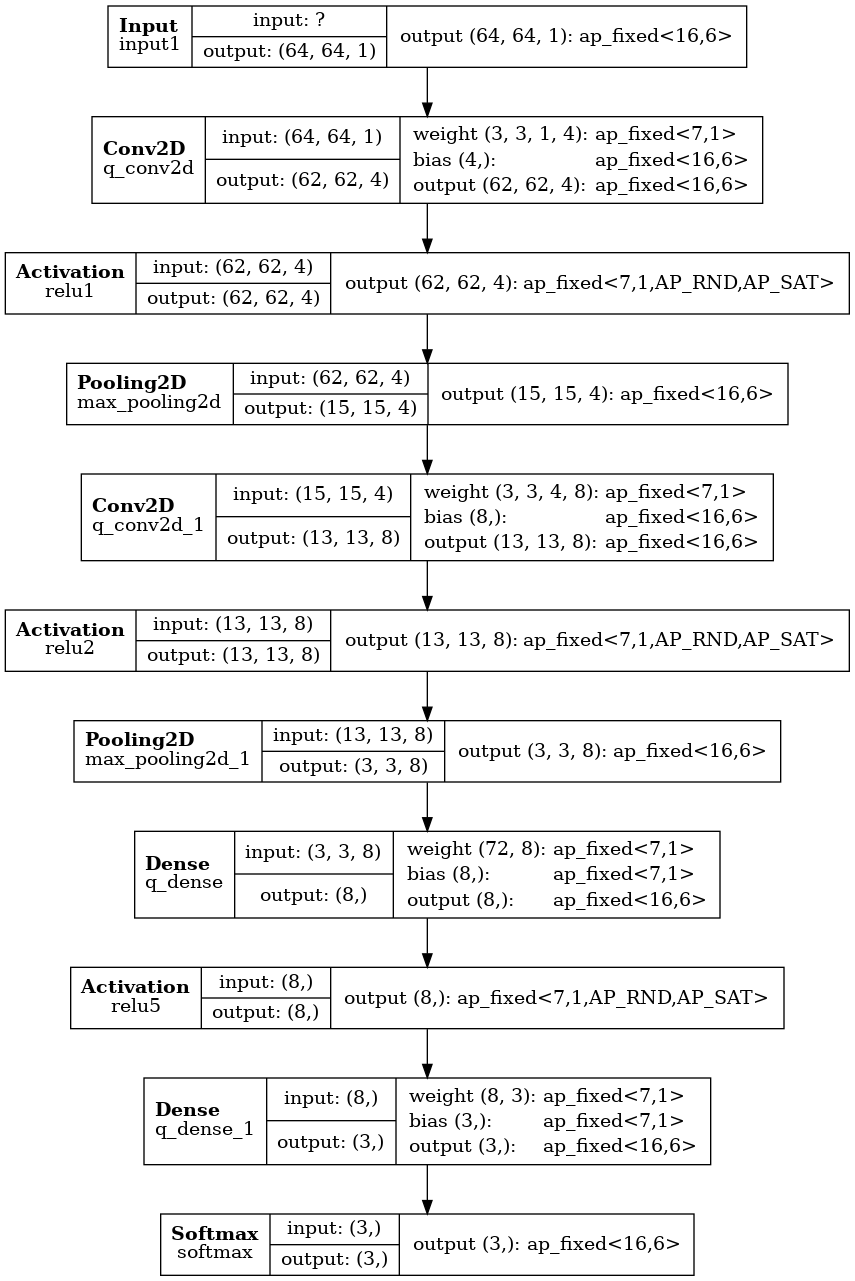

In [33]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

##Compile, predict

In [35]:
hls_model.compile()
y_hls = hls_model.predict(X_test)

Writing HLS project
Done


In [36]:
y_test

array([1, 1, 0, ..., 0, 2, 2])

In [37]:
y_prob

array([[2.7243797e-02, 8.8086122e-01, 9.1894962e-02],
       [1.5873825e-02, 7.0426309e-01, 2.7986306e-01],
       [7.7119225e-01, 1.1451561e-01, 1.1429217e-01],
       ...,
       [7.7119225e-01, 1.1451561e-01, 1.1429217e-01],
       [8.9450437e-04, 3.4784056e-02, 9.6432143e-01],
       [8.9450437e-04, 3.4784056e-02, 9.6432143e-01]], dtype=float32)

In [38]:
print("Keras  Accuracy: {}".format(accuracy_score(y_test, np.argmax(y_prob,axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(y_test, np.argmax(y_hls,axis=1))))


Keras  Accuracy: 0.9330646574382337
hls4ml Accuracy: 0.648677063255651


In [50]:
os.environ['PATH'] = '/scratch/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
hls_model.build(csim=False)

Synthesis report not found.


{'CSimResults': [],
 'CosimResults': [],
 'CosimRTL': 'Verilog',
 'CosimStatus': 'Fail',
 'CosimLatencyMin': 'NA',
 'CosimLatencyMax': 'NA',
 'CosimIntervalMin': 'NA',
 'CosimIntervalMax': 'NA'}

In [ ]:
hls4ml.report.read_vivado_report('model_QKeras/hls4ml_prj/')